# Predicting House Prices 

Nowadays, housing prices are extremely on the rise due to the increase in demand. It is really hard to get your hands on a house and even if you do, it has become normal to pay much more than the original sales price of the house.

When thinking about the sales price of a house, most people think this is a combination of the size of the lot, the amount of bedrooms and the location. However, many more unfamiliar features determine the sales price of a house. Given a dataset with 79 features, both a mixture of categorical and numerical features, we are going to estimate the value of houses in Ames Iowa. Since there are only 1460 training examples the challenge to train a model that generalizes well to new examples arises. Creating a model which predicts housing prices will help to solve real world problems because housing prices can in this way be computed in a more rational way. 

## Import the necessary modules and libraries

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


## Import data

In [2]:
train_data = pd.read_csv('train.csv')

## Inspect data

### Data information

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Missing values

In [28]:
def show_missing_info(df):
    
    '''This function detects missing values in a dataframe and returns a dataframe of features with missing
    values and the number of rows with and percentage of missing values within that feature in descending order.'''
    
    missing_info = df.isna().sum().reset_index(drop=False)
    missing_info.columns = ["column","rows"]
    missing_info["percentage missing"] = (missing_info["rows"]/train_data.shape[0])*100
    missing_info = missing_info[missing_info["rows"]>0].sort_values(by="percentage missing",ascending=False)
    return missing_info

# Show information about features with missing values in the train data
missing_df = show_missing_info(train_data)
print(f'Features with missing values:\n', missing_df)

# Make a list of the top 5 features with the most missing values in the train data
all_missing = list(missing_df['column'])
top5_mv = list(missing_df['column'].head(5))
print(f'\n Features that will be dropped from the dataset:\n', top5_mv)




Features with missing values:
           column  rows  percentage missing
72        PoolQC  1453           99.520548
74   MiscFeature  1406           96.301370
6          Alley  1369           93.767123
73         Fence  1179           80.753425
57   FireplaceQu   690           47.260274
58    GarageType    81            5.547945
59   GarageYrBlt    81            5.547945
60  GarageFinish    81            5.547945
63    GarageQual    81            5.547945
64    GarageCond    81            5.547945
32  BsmtExposure    38            2.602740
35  BsmtFinType2    38            2.602740
30      BsmtQual    37            2.534247
31      BsmtCond    37            2.534247
33  BsmtFinType1    37            2.534247
25    MasVnrType     8            0.547945
26    MasVnrArea     8            0.547945
42    Electrical     1            0.068493

 Features that will be dropped from the dataset:
 ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


### Visualize sale prices

/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

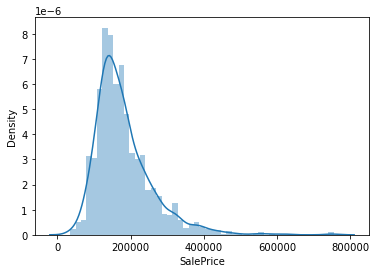

In [5]:
# Select the SalePrice (y) from the training data
X_train = train_data.loc[:, train_data.columns != 'SalePrice']
y_train = train_data['SalePrice']

# Create a histogram with seaborn of the SalePrice (y) from train data
sns.distplot(y_train)

As you can see in the plot, most of the houses are sold for a price between 100000 and 200000 dollars. However, there are outliers on the precier side.

## Prepare data

We will make some adjustments in the data set in order to make the data useful as input to the model.

1. Clean data
    - Drop features that are in the top 5 features that include the most missing values
    - Replace other missing numerical data with the mean value of that feature
    - Replace other missing categorical data with the most common category of that feature)
2. One-hot encode categorical data
3. Select features in data set with a high correlation with the SalePrice
3. Ramdomly devide data set into 70% train data and 30% validation data

In [7]:
def one_hot_encoding(df):
    
    '''One hot encode categorical data from a dataframe.'''
        
    # Select all categorical features and numberical features
    cat_data = df.select_dtypes(include=[object])
    num_data = df.select_dtypes(exclude=[object])
    
    # Create a LabelEncoder object and apply it to each categorical feature in the data
    le = preprocessing.LabelEncoder()
    cat_data_2 = cat_data.apply(le.fit_transform)
    
    # Create an OneHotEncoder object and fit it to all categorical data
    enc = preprocessing.OneHotEncoder()
    enc.fit(cat_data_2)
    onehotlabels = enc.transform(cat_data_2).toarray()
    
    # Get all possible categories from the data
    all_categories = enc.get_feature_names(cat_data_2.columns)

    # Create new dataframe with all possible categories as columns
    cat_data = pd.DataFrame(onehotlabels, columns = all_categories)
    
    # Merge the numerical data with the one hot encoded categorical data again
    result = pd.concat([cat_data, num_data], axis=1).reindex(cat_data.index)
        
    return result


In [8]:
def cleaning(df):
    
    '''This function corrects any missing values in a pandas dataframe and
    returns the cleaned dataframe.'''
    
    # Loop through all the features/columns in the training data
    for column in df:
                
        # if column is in top 5 of columns with most missing data, drop column
        if column in top5_mv:
            df = df.drop(columns=[column])
        
        # check whether the data in each column is numerical
        elif is_numeric_dtype(df[column]):

            # if the data is numerical compute the mean of the whole column values
            column_mean = df[column].mean()

            # replace the missing values in this column with the mean of the column
            df[column] = df[column].fillna(column_mean)

        # replace categorical missing values with the most common categorical value
        else:
            df[column] = df[column].fillna(df[column].value_counts().index[0])
    
    return df

# Clean and one hot encode data in dataframe
train_data_cleaned = cleaning(train_data)
train_data_oh = one_hot_encoding(train_data_cleaned)   


/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Split SalePrice (y) from train data (X)

In [13]:
X_train = train_data_oh.loc[:, train_data_oh.columns != 'SalePrice']
y_train = train_data_oh['SalePrice']

## Select features from the train data with a high correlation with the SalePrice

In [14]:
# Compute correlation coefficients
train_data_oh.corr(method="pearson")

,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_0,Street_1,LotShape_0,LotShape_1,LotShape_2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSZoning_0,1.000000,-0.017926,-0.008742,-0.160278,-0.034792,0.254287,-0.254287,-0.040840,-0.014116,-0.006897,...,-0.055969,0.022243,0.082295,-0.009661,-0.007689,-0.005705,0.002999,0.042344,0.030290,-0.111257
MSZoning_1,-0.017926,1.000000,-0.022722,-0.416608,-0.090435,-0.013866,0.013866,-0.081464,0.023612,-0.017926,...,-0.063687,0.185169,-0.077563,-0.025113,-0.046530,-0.014828,-0.018928,-0.003594,0.004943,0.089950
MSZoning_2,-0.008742,-0.022722,1.000000,-0.203158,-0.044101,-0.006762,0.006762,-0.046176,0.021930,-0.008742,...,-0.022364,-0.029259,0.063286,-0.012246,-0.028443,-0.007231,-0.009230,0.045883,-0.025035,-0.065429
MSZoning_3,-0.160278,-0.416608,-0.203158,1.000000,-0.808585,-0.045348,0.045348,0.261574,0.027175,0.022698,...,0.167734,-0.044253,-0.159896,0.051525,0.061666,0.035591,0.016581,-0.003429,0.012716,0.245063
MSZoning_4,-0.034792,-0.090435,-0.044101,-0.808585,1.000000,0.003127,-0.003127,-0.229711,-0.047949,-0.011491,...,-0.135901,-0.053039,0.190614,-0.038708,-0.033662,-0.028779,-0.006047,-0.017192,-0.017131,-0.288065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PoolArea,-0.005705,-0.014828,-0.007231,0.035591,-0.028779,-0.004413,0.004413,0.017269,-0.011676,0.093544,...,0.073378,0.060762,0.054203,-0.007992,0.051307,1.000000,0.029669,-0.033737,-0.059689,0.092404
MiscVal,0.002999,-0.018928,-0.009230,0.016581,-0.006047,0.022733,-0.022733,0.043950,-0.006713,-0.007282,...,-0.009551,-0.018584,0.018361,0.000354,0.031946,0.029669,1.000000,-0.006495,0.004906,-0.021190
MoSold,0.042344,-0.003594,0.045883,-0.003429,-0.017192,-0.003690,0.003690,0.032942,0.002763,-0.003746,...,0.021011,0.071255,-0.028887,0.029474,0.023217,-0.033737,-0.006495,1.000000,-0.145721,0.046432
YrSold,0.030290,0.004943,-0.025035,0.012716,-0.017131,0.025043,-0.025043,-0.035973,0.004853,-0.026006,...,0.022270,-0.057619,-0.009916,0.018645,0.010694,-0.059689,0.004906,-0.145721,1.000000,-0.028923


In [17]:
def select_correlated_features(X_train, y_train, no_features):
    
    '''This function selects x features (=no_features) from X_train which are most correlated
    with the SalePrice (y_train) and returns this subset of X_train.'''
    
    # Determine correlations of features with the sale price in descending order
    correlations = X_train.corrwith(y_train).sort_values(ascending=False)
    
    # Create lists of features with the x highest correlations with the SalePrice
    top_cor = list(correlations.head(no_features).index.values)

    # Only remain features in df which are in that list
    X_train_subset = X_train[X_train.columns.intersection(top_cor)]
    
    return X_train_subset

X_train_subset = select_correlated_features(X_train, y_train, 10)
print(X_train_subset)
    

      BsmtQual_0  OverallQual  YearBuilt  TotalBsmtSF  1stFlrSF  GrLivArea  \
0            0.0            7       2003          856       856       1710   
1            0.0            6       1976         1262      1262       1262   
2            0.0            7       2001          920       920       1786   
3            0.0            7       1915          756       961       1717   
4            0.0            8       2000         1145      1145       2198   
...          ...          ...        ...          ...       ...        ...   
1455         0.0            6       1999          953       953       1647   
1456         0.0            6       1978         1542      2073       2073   
1457         0.0            7       1941         1152      1188       2340   
1458         0.0            5       1950         1078      1078       1078   
1459         0.0            5       1965         1256      1256       1256   

      FullBath  TotRmsAbvGrd  GarageCars  GarageArea  
0       

## Divide the data into a train and validation set


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train_subset, y_train, test_size=0.2, random_state=42)
